In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [3]:
import os
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD

In [4]:
Class_Num=5
Batch_Size=16
Epoch_Steps=int(4323/Batch_Size)
Image_Shape=(224,224,3)

In [5]:
Image_Train="/home/hemanth/Documents/DeepLearning/flowers"
Model_Name="Model/googlenet_flower.h5"

train_datagen=ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [7]:
generator_main=train_datagen.flow_from_directory(
    Image_Train,
    target_size=(Image_Shape[0],Image_Shape[1]),
    batch_size=Batch_Size,
    class_mode='categorical'
)

Found 4323 images belonging to 5 classes.


In [8]:
def my_generator(generator):
    while True:
        data=next(generator)
        x=data[0]
        y=data[1],data[1],data[1]
        yield x,y
        
train_generator=my_generator(generator_main)

![](https://lh3.googleusercontent.com/-BOy8KVKvCqA/YAUcjhWxwlI/AAAAAAAAsXA/-TjvK8ZrwhAeRzHIXDtUHW4QD1mrAMr7QCK8BGAsYHg/s0/2021-01-17.png)

In [9]:
## Creat model

def inception(x,filters):
    #1x1
    path1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    
    #1*1->3*3
    path2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    path2=Conv2D(filters=filters[1][0],kernel_size=(3,3),strides=1,padding='same',activation='relu')(path2)
    
    #1*1->5*5
    path3=Conv2D(filters=filters[2][0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)
    path3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding='same',activation='relu')(path3)
    
    
    #3*3->1*1
    path4=MaxPooling2D(pool_size=(3,3),strides=1,padding='same')(x)
    path4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding='same',activation='relu')(path4)
    
    
    return Concatenate(axis=-1)([path1,path2,path3,path4])
    
    
    
    

In [11]:
def auxiliary(x,name=None):
    layer=AveragePooling2D(pool_size=(5,5),strides=1,padding='valid')(x)
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=3,padding='same',activation='relu')(layer)
    layer=Flatten()(layer)
    layer=Dense(units=256,activation='relu')(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=Class_Num,activation='softmax',name=name)(layer)
    return layer

![](https://lh3.googleusercontent.com/-gINSR3limpc/YAUgoYCfpcI/AAAAAAAAsXM/NDomP0ouT683tQ1AKwSYyJ6slVmoGglqQCK8BGAsYHg/s0/2021-01-17.png)

In [12]:
def googlenet():
    layer_in=Input(shape=Image_Shape)
    
    ##Stage-1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=2,padding='same',activation='relu')(layer_in)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    ## stage-2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer)
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding='same',activation='relu')(layer)
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    ## stage-3
    layer=inception(layer,[64,(96,128),(16,32),32])#3a
    layer=inception(layer,[128,(128,192),(32,96),64])#3b
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    ##Stage-4
    layer=inception(layer,[192,(96,208),(16,48),64])#4a
    aux1=auxiliary(layer,name='aux1')
    layer=inception(layer,[160,(112,224),(24,64),64])#4b
    layer=inception(layer,[128,(128,256),(24,64),64])#4c
    layer=inception(layer,[112,(144,288),(32,64),64])#4d
    aux2=auxiliary(layer,name='aux2')
    layer=inception(layer,[256,(192,384),(32,128),128])#4e
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(layer)
    
    ## stage-5
    layer=inception(layer,[256,(160,320),(32,128),128])#3a
    layer=inception(layer,[384,(192,384),(48,128),128])#3b
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding='valid')(layer)
    
    ## Stage-6
    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation='linear')(layer)
    main=Dense(units=Class_Num,activation='softmax',name='main')(layer)
    
    model=Model(inputs=layer_in,outputs=[main,aux1,aux2])
    
    return model
    
    
    
    
    

In [13]:
model=googlenet()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [15]:
optimizer=['Adam','SGD','Adam','SGD']
epochs=[20,30,20,30]
history_all={}


In [16]:
for i in range(len(optimizer)):
    print("using optimizer:"+optimizer[i]+',Epoch:'+str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy',
                 loss_weights={'main':1.0,'aux1':0.3,'aux2':0.3},
                 optimizer=optimizer[i],metrics=['accuracy'])
    
    train_history=model.fit(
            train_generator,
            steps_per_epoch=Epoch_Steps,
            shuffle=True
            )
    
    ## Save History
    
    if len(history_all)==0:
        history_all={key:[] for key in train_history.history}
        
    for key in history_all:
        history_all[key].extend(train_history.history[key])

model.save(Model_Name)
    
    

using optimizer:Adam,Epoch:20
270/270 [==============================] - 614s 2s/step - loss: 2.3473 - main_loss: 1.5018 - aux1_loss: 1.3873 - aux2_loss: 1.4311 - main_accuracy: 0.3435 - aux1_accuracy: 0.3976 - aux2_accuracy: 0.3510
using optimizer:SGD,Epoch:30
270/270 [==============================] - 585s 2s/step - loss: 1.8292 - main_loss: 1.1522 - aux1_loss: 1.1095 - aux2_loss: 1.1471 - main_accuracy: 0.4857 - aux1_accuracy: 0.5315 - aux2_accuracy: 0.4902
using optimizer:Adam,Epoch:20
270/270 [==============================] - 565s 2s/step - loss: 1.8918 - main_loss: 1.1981 - aux1_loss: 1.1365 - aux2_loss: 1.1760 - main_accuracy: 0.4713 - aux1_accuracy: 0.5328 - aux2_accuracy: 0.4725
using optimizer:SGD,Epoch:30
270/270 [==============================] - 479s 2s/step - loss: 1.6175 - main_loss: 1.0243 - aux1_loss: 0.9653 - aux2_loss: 1.0122 - main_accuracy: 0.5972 - aux1_accuracy: 0.6139 - aux2_accuracy: 0.5947


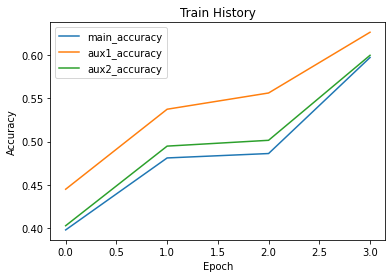

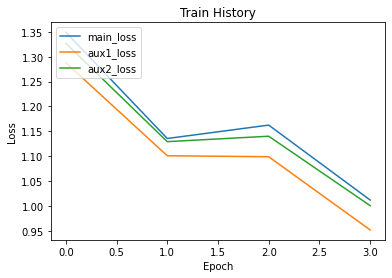

In [18]:
def show_train_history(history,xlabel,ylabel,train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train,loc='upper left')
    plt.show()
    
    
    
show_train_history(history_all,'Epoch','Accuracy',('main_accuracy','aux1_accuracy','aux2_accuracy'))
show_train_history(history_all,'Epoch','Loss',('main_loss','aux1_loss','aux2_loss'))

    

![](https://developer.ridgerun.com/wiki/images/e/eb/Googlenet.png)